In [51]:
import os
import librosa
import numpy as np
import csv
from sklearn.preprocessing import StandardScaler

# MFCC parametreleri
n_mfcc = 40  # MFCC özelliği sayısı
frame_length = 25  # Milisaniye cinsinden frame uzunluğu
frame_stride = 10  # Milisaniye cinsinden frame kayması
max_duration = 3  # Maksimum ses süresi (saniye)

# MFCC ve Chroma özelliklerini çıkarmak için fonksiyon
def extract_audio_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)
        # Ses uzunluğunu standartlaştırma
        y = librosa.util.fix_length(y, size=int(sr * max_duration))
        
        # MFCC
        hop_length = int(frame_stride * sr / 1000)
        n_fft = int(frame_length * sr / 1000)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)
        mfcc_mean = np.mean(mfcc, axis=1)
        
        # Chroma
        chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=hop_length)
        chroma_mean = np.mean(chroma, axis=1)
        
        # Tüm özellikleri birleştir
        features = np.concatenate([mfcc_mean, chroma_mean])
        return features
    except Exception as e:
        print(f"Dosya yükleme hatası: {file_path}, Hata: {e}")
        with open('error_log.txt', 'a') as error_file:
            error_file.write(f"{file_path}, Hata: {e}\n")
        return None

# Özellikleri çıkar ve CSV dosyasına kaydet
def extract_features_and_save_to_csv(directory, output_csv_file):
    features = []  # Özellikleri depolamak için liste
    labels = []    # Etiketleri depolamak için liste

    # Dosyaya yazmak için csv.writer
    with open(output_csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        
        # Başlık satırını ekle
        header = [f"MFCC_{i+1}" for i in range(n_mfcc)] + [f"Chroma_{i+1}" for i in range(12)] + ["Kişi", "Ses Türü"]
        writer.writerow(header)
        
        # Klasördeki her kişiyi (üst klasör) işleyelim
        for person in os.listdir(directory):
            person_path = os.path.join(directory, person)
            if os.path.isdir(person_path):  # Kişi klasörlerini kontrol et
                # Alt klasörleri (örneğin korku, mutlu) işleyelim
                for sub_folder in os.listdir(person_path):
                    sub_folder_path = os.path.join(person_path, sub_folder)
                    if os.path.isdir(sub_folder_path):  # Alt klasörleri kontrol et
                        for file in os.listdir(sub_folder_path):
                            if file.endswith('.wav'):
                                file_path = os.path.join(sub_folder_path, file)

                                # Özellikleri çıkar
                                features_data = extract_audio_features(file_path)
                                if features_data is not None:
                                    # Özellikleri kaydet
                                    writer.writerow(list(features_data) + [person, sub_folder])
                                    features.append(features_data)
                                    labels.append([person, sub_folder])

    # Özellikleri normalleştirme
    if features:
        scaler = StandardScaler()
        features_normalized = scaler.fit_transform(features)
        print(f"Özellikler normalleştirildi. Boyut: {features_normalized.shape}")
    else:
        print("Hiç özellik çıkartılamadı.")
    print(f"Etiketler: {labels[:5]}")  # İlk 5 etiketi yazdır

# Klasör yolunu ve üst klasör yapısını belirtin
root_path = r'C:\VoiceProject\Voice'  # Ses dosyalarınızın bulunduğu ana klasör
output_csv_file = 'mfcc_chroma_features.csv'  # Özelliklerin kaydedileceği dosya

# Özellikleri çıkar ve CSV dosyasına kaydet
extract_features_and_save_to_csv(root_path, output_csv_file)

print(f"MFCC ve Chroma özellikleri '{output_csv_file}' dosyasına başarıyla kaydedildi.")


Özellikler normalleştirildi. Boyut: (97, 52)
Etiketler: [['elif', 'korku'], ['elif', 'korku'], ['elif', 'korku'], ['elif', 'korku'], ['elif', 'korku']]
MFCC ve Chroma özellikleri 'mfcc_chroma_features.csv' dosyasına başarıyla kaydedildi.


In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import class_weight
import numpy as np

# CSV dosyasını yükle
csv_file = 'mfcc_chroma_features.csv'
data = pd.read_csv(csv_file)

# Özellikler ve etiketler
X = data.iloc[:, :-2].values  # Özellik sütunları (MFCC ve Chroma)
y = data.iloc[:, -2].values  # Kişi etiketleri

# Etiketleri sayısal formata dönüştür
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Etiketlerin dağılımını kontrol et
label_counts = pd.Series(y).value_counts()
print("Etiketlerin Dağılımı:")
print(label_counts)

# Sınıf ağırlıklarını hesaplama (dengesiz veri setleri için önerilir)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Sınıf Ağırlıkları:")
print(class_weights_dict)

# Özellikleri ölçeklendir
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Eğitim ve test setlerini ayır (stratify=y_encoded ile dengeli veri bölmesi)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Eğitim setinde sınıf dağılımını kontrol et
train_class_counts = pd.Series(y_train).value_counts()
test_class_counts = pd.Series(y_test).value_counts()
print("\nEğitim Seti Sınıf Dağılımı:")
print(train_class_counts)
print("\nTest Seti Sınıf Dağılımı:")
print(test_class_counts)

# Eğitim ve test setlerinin boyutlarını yazdır
print(f"\nEğitim seti boyutu: {X_train.shape}")
print(f"Test seti boyutu: {X_test.shape}")


Etiketlerin Dağılımı:
elif     36
irem     31
nazli    30
Name: count, dtype: int64
Sınıf Ağırlıkları:
{0: 0.8981481481481481, 1: 1.043010752688172, 2: 1.0777777777777777}

Eğitim Seti Sınıf Dağılımı:
0    28
1    25
2    24
Name: count, dtype: int64

Test Seti Sınıf Dağılımı:
0    8
2    6
1    6
Name: count, dtype: int64

Eğitim seti boyutu: (77, 52)
Test seti boyutu: (20, 52)


Model eğitiliyor...

Model Performansı:
              precision    recall  f1-score   support

        elif       1.00      1.00      1.00         8
        irem       1.00      0.83      0.91         6
       nazli       0.86      1.00      0.92         6

    accuracy                           0.95        20
   macro avg       0.95      0.94      0.94        20
weighted avg       0.96      0.95      0.95        20

Doğruluk Skoru: 0.95


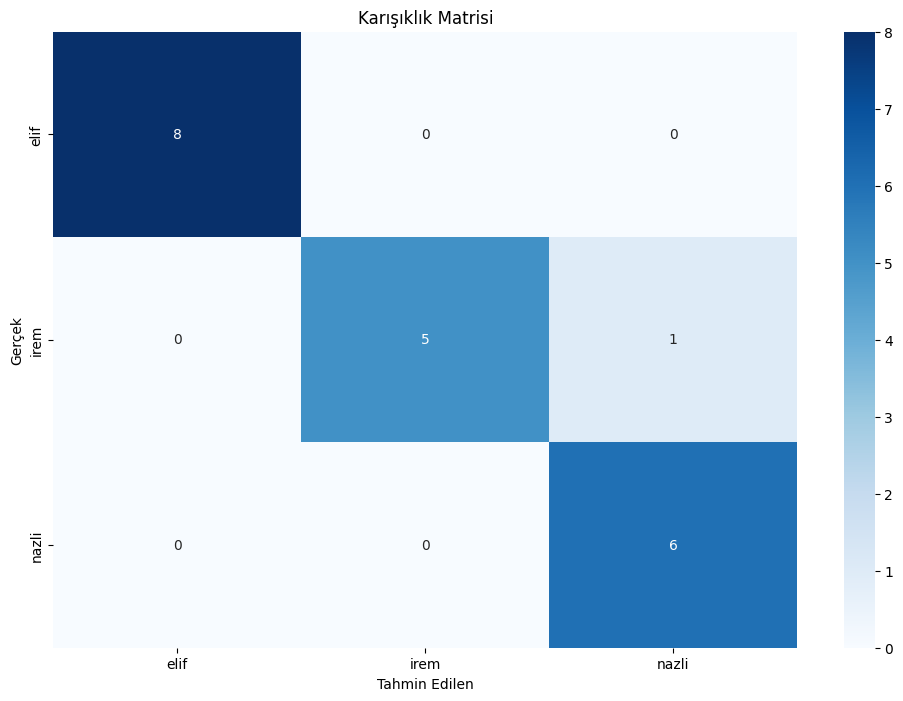


En Önemli 10 Özellik:
1. Özellik: MFCC_2, Önem: 0.2276
2. Özellik: MFCC_14, Önem: 0.0883
3. Özellik: MFCC_9, Önem: 0.0721
4. Özellik: MFCC_13, Önem: 0.0566
5. Özellik: MFCC_23, Önem: 0.0458
6. Özellik: Chroma_7, Önem: 0.0447
7. Özellik: MFCC_19, Önem: 0.0386
8. Özellik: MFCC_12, Önem: 0.0360
9. Özellik: MFCC_39, Önem: 0.0323
10. Özellik: MFCC_31, Önem: 0.0317

Yanlış Sınıflandırılan Örnek Sayısı: 1


In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Model oluştur
clf = RandomForestClassifier(
    n_estimators=10,      # Daha fazla ağaç, daha iyi genelleme yapabilir
    max_depth=5,        # Ağaçların maksimum derinliği sınırsız
    min_samples_split=2,   # Dallanma için minimum örnek sayısı
    min_samples_leaf=1,    # Yaprakta minimum örnek sayısı
    class_weight="balanced",  # Dengeli sınıf ağırlıkları kullan
    random_state=42,            # Paralel işlem için tüm CPU çekirdeklerini kullan
)

print("Model eğitiliyor...")
# Modeli eğit
clf.fit(X_train, y_train)

# Test seti üzerinde tahmin yap
y_pred = clf.predict(X_test)

# Performans değerlendirmesi
print("\nModel Performansı:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
accuracy = accuracy_score(y_test, y_pred)
print(f"Doğruluk Skoru: {accuracy:.2f}")

# Karışıklık Matrisi Görselleştirme
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Karışıklık Matrisi')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.show()

# Özellik Önem Düzeyleri
feature_importances = clf.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]

print("\nEn Önemli 10 Özellik:")
for i in range(10):
    print(f"{i+1}. Özellik: {data.columns[sorted_idx[i]]}, Önem: {feature_importances[sorted_idx[i]]:.4f}")

# Modelin doğru sınıflandırmada zorlandığı sınıfları belirleme
misclassified_indices = np.where(y_test != y_pred)[0]
print(f"\nYanlış Sınıflandırılan Örnek Sayısı: {len(misclassified_indices)}")


In [54]:
import joblib

# Modeli ve etiket kodlamasını kaydet
joblib.dump(clf, 'speaker_recognition_model.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("Model başarıyla kaydedildi!")


Model başarıyla kaydedildi!


In [59]:
import sounddevice as sd
import librosa
import numpy as np
import joblib

# Model ve diğer araçları yükle
clf = joblib.load('speaker_recognition_model.pkl')
label_encoder = joblib.load('label_encoder.pkl')
scaler = joblib.load('scaler.pkl')

def record_audio(duration=3, sr=16000):
    """
    Mikrofon ile belirli bir süre ses kaydeder.
    duration: Kaydedilecek sesin süresi (saniye cinsinden)
    sr: Örnekleme oranı (Hz)
    """
    print("Konuşmaya başlayın...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype='float32')
    sd.wait()  # Kaydın bitmesini bekle
    print("Kayıt tamamlandı!")
    return audio.flatten(), sr

def extract_features_from_audio(audio, sr, n_mfcc=40):
    """
    Ses verisinden MFCC ve Chroma özelliklerini çıkarır.
    """
    try:
        # MFCC özellikleri
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        mfcc_mean = np.mean(mfcc, axis=1)
        
        # Chroma özellikleri
        chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
        chroma_mean = np.mean(chroma, axis=1)
        
        # Tüm özellikleri birleştir
        features = np.concatenate([mfcc_mean, chroma_mean])
        return features
    except Exception as e:
        print(f"Özellik çıkarımı hatası: {e}")
        return None

def predict_from_microphone():
    # Ses kaydet
    audio, sr = record_audio(duration=3)  # 3 saniyelik kayıt
    features = extract_features_from_audio(audio, sr)
    
    if features is not None:
        # Özellikleri ölçeklendir
        features_scaled = scaler.transform([features])
        
        # Tahmin yap
        predicted_label = clf.predict(features_scaled)
        
        # Etiketi çöz
        speaker_name = label_encoder.inverse_transform(predicted_label)
        print(f"Tahmin edilen konuşmacı: {speaker_name[0]}")
    else:
        print("Tahmin yapılamadı. Özellikler çıkarılamadı.")

if __name__ == "__main__":
    predict_from_microphone()


Konuşmaya başlayın...
Kayıt tamamlandı!
Tahmin edilen konuşmacı: nazli
